# setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from teren import dir_act_utils as dau
from teren import utils as tu
from teren import direction, measure, experiment_context
from transformer_lens import HookedTransformer
from teren.typing import *

device = tu.get_device_str()
print(f"{device=}")

device='cuda'


In [3]:
LAYER = 11
SEQ_LEN = 4
INFERENCE_TOKENS = 12_800
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // SEQ_LEN
print(f"{INFERENCE_BATCH_SIZE=}")

N_PROMPTS = INFERENCE_BATCH_SIZE


input_ids = dau.get_input_ids(chunk=0, seq_len=SEQ_LEN)[:N_PROMPTS]
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

INFERENCE_BATCH_SIZE=3200
Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
exctx = experiment_context.ExperimentContext(
    model=model,
    layer=LAYER,
    input_ids=input_ids,
    acts_q_range=(0.01, 0.95),
    batch_size=INFERENCE_BATCH_SIZE,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
dir = torch.randn(model.cfg.d_model)
dir /= dir.norm()
dir = direction.Direction(dir, exctx)
dir.act_min, dir.act_max

(1.7189607620239258, 130.74974060058594)

In [7]:
dir.process_measure(measure.jsd_measure)

In [8]:
dir.measurements_by_measure[measure.jsd_measure].selected.shape

torch.Size([12199, 3])

In [9]:
matrix_measure = dir.act_matrix_measure(n_act=10, measure=measure.jsd_measure)
matrix_measure.shape

torch.Size([10, 10, 12199])

In [10]:
values, indices = dau.compute_min_convex_scores(matrix_measure)
print(values.min())
print(values.shape)

tensor(0.1570)
torch.Size([12199])


In [11]:
min_lines = torch.gather(
    matrix_measure,
    index=indices.unsqueeze(0).unsqueeze(0).expand(-1, 10, -1),
    dim=0,
).squeeze()
min_lines.shape

torch.Size([10, 12199])

In [12]:
sorted_i = torch.argsort(values)[:50:5]

In [13]:
lines = min_lines[:, sorted_i]
lines.shape

torch.Size([10, 10])

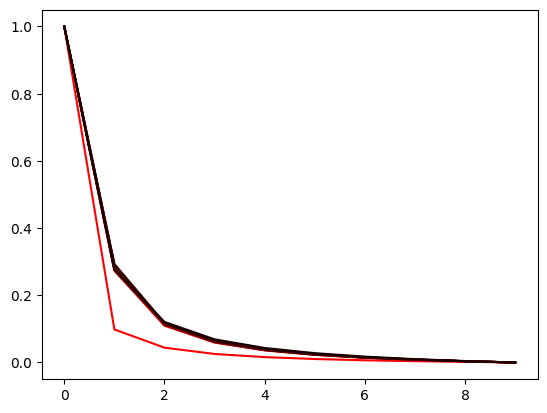

In [14]:
import matplotlib.pyplot as plt

for i, line in enumerate(lines.T):
    plt.plot(line / line.max(), color=(1 - i / 10, 0, 0))